# Information Retrieval 1#
## Assignment 2: Retrieval models [100 points] ##

In this assignment you will get familiar with basic and advanced information retrieval concepts. You will implement different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Wednesday, January 31st**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](piazza.com/university_of_amsterdam/spring2018/52041inr6y/home).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [1]:
import numpy as np

In [2]:
import logging
import sys
import os

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example
Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [3]:
import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [4]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [5]:
example_document = index.document(index.document_base())
print(example_document)

('AP890425-0001', (1360, 192, 363, 0, 880, 0, 200, 0, 894, 412, 92160, 3, 192, 0, 363, 34, 1441, 0, 174134, 0, 200, 0, 894, 412, 2652, 0, 810, 107, 49, 4903, 420, 0, 1, 48, 35, 489, 0, 35, 687, 192, 243, 0, 249311, 1877, 0, 1651, 1174, 0, 2701, 117, 412, 0, 810, 391, 245233, 1225, 5838, 16, 0, 233156, 3496, 0, 393, 17, 0, 2435, 4819, 930, 0, 0, 200, 0, 894, 0, 22, 398, 145, 0, 3, 271, 115, 0, 1176, 2777, 292, 0, 725, 192, 0, 0, 50046, 0, 1901, 1130, 0, 192, 0, 408, 0, 243779, 0, 0, 553, 192, 0, 363, 0, 3747, 0, 0, 0, 0, 1176, 0, 1239, 0, 0, 1115, 17, 0, 0, 585, 192, 1963, 0, 0, 412, 54356, 0, 773, 0, 0, 0, 192, 0, 0, 1130, 0, 363, 0, 545, 192, 0, 1174, 1901, 1130, 0, 4, 398, 145, 39, 0, 577, 0, 355, 0, 491, 0, 6025, 0, 0, 193156, 88, 34, 437, 0, 0, 1852, 0, 828, 0, 1588, 0, 0, 0, 2615, 0, 0, 107, 49, 420, 0, 0, 190, 7, 714, 2701, 0, 237, 192, 157, 0, 412, 34, 437, 0, 0, 200, 6025, 26, 0, 0, 0, 0, 363, 0, 22, 398, 145, 0, 200, 638, 126222, 6018, 0, 880, 0, 0, 161, 0, 0, 319, 894, 2701, 

Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

In [6]:
token2id, id2token, _ = index.get_dictionary()
print(list(id2token.items())[:15])

[(1, 'new'), (2, 'percent'), (3, 'two'), (4, '1'), (5, 'people'), (6, 'million'), (7, '000'), (8, 'government'), (9, 'president'), (10, 'years'), (11, 'state'), (12, '2'), (13, 'states'), (14, 'three'), (15, 'time')]


Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [7]:
print([id2token[word_id] for word_id in example_document[1] if word_id > 0])

['52', 'students', 'arrested', 'takeover', 'university', 'massachusetts', 'building', 'fifty', 'two', 'students', 'arrested', 'tuesday', 'evening', 'occupying', 'university', 'massachusetts', 'building', 'overnight', 'protest', 'defense', 'department', 'funded', 'research', 'new', 'york', 'city', 'thousands', 'city', 'college', 'students', 'got', 'unscheduled', 'holiday', 'demonstrators', 'occupied', 'campus', 'administration', 'building', 'protest', 'possible', 'tuition', 'increases', 'prompting', 'officials', 'suspend', 'classes', '60', 'police', 'riot', 'gear', 'arrived', 'university', 'massachusetts', '5', 'p', 'm', 'two', 'hours', 'later', 'bus', 'drove', 'away', '29', 'students', 'camped', 'memorial', 'hall', 'students', 'charged', 'trespassing', '23', 'students', 'arrested', 'lying', 'bus', 'prevent', 'leaving', 'police', '300', 'students', 'stood', 'building', 'chanting', 'looking', 'students', 'hall', 'arrested', '35', 'students', 'occupied', 'memorial', 'hall', '1', 'p', 'm',

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [8]:
query_tokens = index.tokenize("University of Massachusetts")
print("Query by tokens:", query_tokens)
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)

Query by tokens: ['university', '', 'massachusetts']
Query by ids with stopwords: [200, 0, 894]
Query by ids without stopwords: [200, 894]


Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [9]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens),matching_words/float(len(example_document[1]))*100))

Document AP890425-0001 has 13 word matches with query: "university  massachusetts".
Document AP890425-0001 and query "university  massachusetts" have a 2.5% overlap.


While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [10]:
import collections
import io
import logging
import sys

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

with open('./ap_88_89/topics_title', 'r') as f_topics:
    print(parse_topics([f_topics]))

OrderedDict([('51', 'Airbus Subsidies'), ('52', 'South African Sanctions'), ('53', 'Leveraged Buyouts'), ('54', 'Satellite Launch Contracts'), ('55', 'Insider Trading'), ('56', 'Prime (Lending) Rate Moves, Predictions'), ('57', 'MCI'), ('58', 'Rail Strikes'), ('59', 'Weather Related Fatalities'), ('60', 'Merit-Pay vs. Seniority'), ('61', 'Israeli Role in Iran-Contra Affair'), ('62', "Military Coups D'etat"), ('63', 'Machine Translation'), ('64', 'Hostage-Taking'), ('65', 'Information Retrieval Systems'), ('66', 'Natural Language Processing'), ('67', 'Politically Motivated Civil Disturbances'), ('68', 'Health Hazards from Fine-Diameter Fibers'), ('69', 'Attempts to Revive the SALT II Treaty'), ('70', 'Surrogate Motherhood'), ('71', 'Border Incursions'), ('72', 'Demographic Shifts in the U.S.'), ('73', 'Demographic Shifts across National Boundaries'), ('74', 'Conflicting Policy'), ('75', 'Automation'), ('76', 'U.S. Constitution - Original Intent'), ('77', 'Poaching'), ('78', 'Greenpeace'

### Task 1: Implement and compare lexical IR methods [35 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html) and 
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[5 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand who the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [11]:
import time
start_time = time.time()

with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')

num_documents = index.maximum_document() - index.document_base()

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation.

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

total_terms = 0

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.
Inverted index creation took 42.41233420372009 seconds.


In [12]:
def run_retrieval(model_name, score_fn, hyperparameters):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    run_out_path = '{}.run'.format(model_name)
    print(run_out_path)
    if os.path.exists(run_out_path):
        return

    retrieval_start_time = time.time()

    print('Retrieving using', model_name)

    print("starting creating data")
    t1 = time.time()
    data = {}

    # TODO: fill the data dictionary. 
    # The dictionary data should have the form: query_id --> (document_score, external_doc_id)
    
    if model_name[0:3] == "plm":
        for query_id in tokenized_queries:
            query_token_ids = tokenized_queries[query_id]
            result = []
            
            good_docs = [k for score,k in tfidf_topN(query_id,10)]

            for k in good_docs:
                doc_score = score_fn(k, query_token_ids, hyperparameters)
                doc_id = index.document(k)[0]
                result.append( (doc_score, doc_id) )

            data[query_id] = result
    else:
        # go through all queries
        for query_id in tokenized_queries:

            query_token_ids = tokenized_queries[query_id]

            # For the query corresponding to query_id, we calculate doc_scores of all docs for that query
            result = []

            # for each "good" document, calculate the doc_score, and append to results (doc_score, doc_id)
            good_docs = []
            for token_id in query_token_ids:
                for doc in inverted_index[token_id].keys():
                    good_docs.append(doc)
            good_docs = set(good_docs)

            for k in good_docs:
                doc_score = score_fn(k, query_token_ids, hyperparameters)
                doc_id = index.document(k)[0]
                result.append( (doc_score, doc_id) )

            data[query_id] = result
    
    
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)

    print("finished creating data, took " + str(time.time() - t1) + " seconds.")

    return 0
#    return data

In [13]:
# returns sorted as [(doc_score, int_doc_id),,...]
#[k for score,k in tfidf_topN(query_id,N)] to get only the int_doc_id's

def tfidf_topN(query_id, N):   
    query_token_ids = tokenized_queries[query_id]
        
    # For the query corresponding to query_id, we calculate doc_scores of all docs for that query
    result = []
    
    # for each "good" document, calculate the doc_score, and append to results (doc_score, doc_id)
    good_docs = []
    for token_id in query_token_ids:
        for doc in inverted_index[token_id].keys():
            good_docs.append(doc)
    good_docs = set(good_docs)
        
    for k in good_docs:
        doc_score = tfidf(k, query_token_ids, [])
        result.append( (doc_score, k) )
                          
    result.sort(key=lambda tup : tup[0], reverse=True)
    
    
    return result[0:N]


In [14]:
#tfidf, hyperparameters = []
def tfidf(int_document_id, query_term_id, hyperparameters): #document_term_freq):
    # int_document_id = number
    # query_term_id = list of query_token_id's
    # document_term_freq = list of document frequenties of words in query
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """
    # TODO implement the function
    
    # for a given query q, to score a document d, we have:
    #
    # score(q,d) = sum tf-idf_t_d, for all t in q
    #
    # tf-idf_td = tf(t,d) * idf(t)
    # tf(t,d) = term frequency of t in d = count t in d
    # idf(t) = inverse document frequency of t = log(N / df(t)) = log(N) - log(df(t))
    # N = total number of documents in collection
    # df(t) = document frequency of t = #{d | tf(t,d) > 0}     <--- so depends on whole collection of documents
    
    score = 0
    N = num_documents # is number of total documents in collection
    
    for k in range(0,len(query_term_id)):
        q_token_id = query_term_id[k]
        if int_document_id in inverted_index[q_token_id]:
            tf = inverted_index[q_token_id][int_document_id]
        else:
            tf = 0

        df = len(inverted_index[q_token_id].keys()) #document_term_freq[k]
        idf = np.log(N) - np.log(df)
        
        score = score + tf*idf
    
    return score

# combining the two functions above:
#x = run_retrieval('tfidf', tfidf)

# TODO implement the rest of the retrieval functions 

#bm25, hyperparameters = [k1, b]
def bm25(int_document_id, query_term_id, hyperparameters):
    
    # parameters as k1=1.2 , b=0.75
    # Ld = length d, Lavg = avg length of a document
    # bm25(q,d) = sum (log(N/df(t)) * (k1+1)*tf(t,d) / (k1*((1-b) + b*Ld/Lavg) + tf(t,d)) ) for t in q
    
    score = 0
    N = num_documents # is number of total documents in collection
    
    # parameters
    k1 = hyperparameters[0]
    b = hyperparameters[1]
    # C:= k1*((1-b) + b*Ld/Lavg)
    C = k1 * ((1-b) + b * document_lengths[int_document_id] / avg_doc_length)
    
    for k in range(0,len(query_term_id)):
        q_token_id = query_term_id[k]
        if int_document_id in inverted_index[q_token_id]:
            tf = inverted_index[q_token_id][int_document_id]
        else:
            tf = 0
    
        df = len(inverted_index[q_token_id].keys())
        idf = np.log(N) - np.log(df)
        
        score = score + idf * (k1+1)*tf / (C + tf)
    
    return score

    
# TODO implement tools to help you with the analysis of the results.


In [15]:
# background probability for a word w, p(w|C), we esitimate it by "words contributing equally,
# meaning p(w|C) = tf(w,C) / |C|

#Jelinek Mercer, hyperparameters = [lambda]
def jelinek_mercer(int_document_id, query_term_id, hyperparameters):
    # score(q,d) = log( p(q|theta_d)  * p(d) ), assume p(d) is uniform -> doesnt matter, so can get rid of it
    # ->  score(q,d) = log( p(q|theta_d) )
    #                = log( prod p(q_i | theta_d) )
    #                = log(p(w1|d)) + ... + log(p(wn|d))?
    #
    # P(w | d) = lambda * tf(w,d) / |d| + (1-lambda) * tf(w,C) / |C|
    #
    
    # parameter lambda
    param_lambda = hyperparameters[0]

    score = 0
    d_length = document_lengths[int_document_id]
    C_length = total_terms
    
    for q_token_id in query_term_id:
        if int_document_id in inverted_index[q_token_id]:
            tf_wd = inverted_index[q_token_id][int_document_id]
        else:
            tf_wd = 0
        tf_wC = collection_frequencies[q_token_id]
        sub_score = param_lambda * tf_wd / d_length + (1-param_lambda)* tf_wC / C_length
        
        score = score + np.log(sub_score)
    
    return score
    
#DirichletPrior, hyperparameter = [mus]
def dirichlet_prior(int_document_id, query_term_id, hyperparameters):
    # P(w | d) = ( tf(w,d) + mu*P(w|C) ) / (|d| + mu)
    #          = ( tf(w,d) + mu*tf(w,C) / |C| ) / (|d| + mu)
    #          = |d|/(|d|+mu) * tf(w,d)/|d|   + mu/(mu+|d|)* tf(w,C) / |C|
    
    # parameter mu
    param_mu = hyperparameters[0]
    
    score = 0
    d_length = document_lengths[int_document_id]
    C_length = total_terms

    for q_token_id in query_term_id:
        if int_document_id in inverted_index[q_token_id]:
            tf_wd = inverted_index[q_token_id][int_document_id]
        else:
            tf_wd = 0
        tf_wC = collection_frequencies[q_token_id]
        sub_score = (tf_wd + param_mu*tf_wC/C_length) / (d_length + param_mu)
        
        score = score + np.log(sub_score)
    
    return score
    
#Absolute discounting, hyperparameters = [delta]
def absolute_discounting(int_document_id, query_term_id, hyperparameters):
    # P(w | d) = max(tf(w,d) - delta,0) / |d| + delta * |d|_u / |d| * p(w|C)
    #          = max(tf(w,d) - delta,0) / |d| + delta * |d|_u / |d| * tf(w,C)/|C|
    #
    
    # parameter delta
    param_delta = hyperparameters[0]
    
    score = 0
    d_length = document_lengths[int_document_id]
    d_length_u = len(set(index.document(int_document_id)[1]))
    C_length = total_terms
    
    for q_token_id in query_term_id:
        if int_document_id in inverted_index[q_token_id]:
            tf_wd = inverted_index[q_token_id][int_document_id]
        else:
            tf_wd = 0
        tf_wC = collection_frequencies[q_token_id]
        sub_score = max(tf_wd-param_delta,0) / d_length  + param_delta * d_length_u / d_length * tf_wC / C_length
        
        score = score + np.log(sub_score)

    return score

In [16]:
def kernel_gaussian(i,j,sigma):
    return np.exp(-(i-j)**2 / (2*sigma**2))

def kernel_triangle(i,j,sigma):
    if np.abs(i-j) <= sigma:
        return 1- np.abs(i-j) / sigma
    else:
        return 0.0
    
def kernel_cosine(i,j,sigma):
    if np.abs(i-j) <= sigma:
        return 0.5*(1+np.cos(np.abs(i-j) * np.pi / sigma))
    else:
        return 0.0

def kernel_circle(i,j,sigma):
    if np.abs(i-j) <= sigma:
        return np.sqrt(1 - (np.abs(i-j) / sigma)**2)
    else:
        return 0.0
    
def kernel_passage(i,j,sigma):
    if np.abs(i-j) <= sigma:
        return 1
    else:
        return 0.0

def calc_Zi(kernel_function,sigma,i,N):
    if kernel_function == kernel_gaussian:
        Zi = 1
    elif kernel_function == kernel_triangle:
        Zi = 1 + sigma
    elif kernel_function == kernel_cosine:
        Zi = 1
    elif kernel_function == kernel_circle:
        Zi = 1
    elif kernel_function == kernel_passage:
        Zi = 1 + 2*sigma
    return Zi
    
# PLM, hyperparameters = [kernel_function, sigma, mu]
def plm(int_document_id, query_term_id, hyperparameters):
    score=0.0

    kernel_function = hyperparameters[0]
    param_sigma = hyperparameters[1]
    param_mu = hyperparameters[2]
    
    doc = index.document(int_document_id)[1] # gives for example (0,12,3,0,43,0,2,4,342,...)
    doc_length = len(doc)
    
    # need to calculate c'(w,i) for each word in query and position i in document
    c_prime = np.zeros((len(query_term_id),doc_length))
    for n in range(0,len(query_term_id)):
        indices = [i for i,e in enumerate(doc) if e == query_term_id[n]]
        for j in indices:
            for i in range(0,doc_length):
                c_prime[n][i] += kernel_function(i,j,param_sigma)
                
    
    # we do dirichlet smoothing for this position language model
    # p(w|D,i) = ( c'(w,i) + mu*p(w|C) ) / (Zi + mu)
    # Zi = sum_j=1^n k(i,j), p(w|C)=tf(w,C)/|C|
    Zi=0.0
    for j in range(0,doc_length):
        Zi += kernel_function(int(doc_length/2),j,param_sigma)

    p_wDi = {}
    C_length = total_terms
    for query_token_id in query_term_id:
        tf_wC = collection_frequencies[query_token_id]
        p_wDi[query_token_id] = (c_prime[n] + param_mu*tf_wC/C_length) / (Zi + param_mu)

    
    # now calculate plm scores for each position
    plm_score = np.zeros(doc_length)
    for i in range(0,doc_length):
        for query_token_id in query_term_id:
            plm_score[i] = plm_score[i] + p_wDi[query_token_id][i]
    
    score = max(plm_score)
    return score

In [ ]:
run_retrieval('tfidf', tfidf, [])
run_retrieval('bm25', bm25, [1.2,0.75])

In [ ]:
run_retrieval('jelinek_mercer_01', jelinek_mercer, [0.1])
run_retrieval('jelinek_mercer_05', jelinek_mercer, [0.5])
run_retrieval('jelinek_mercer_09', jelinek_mercer, [0.9])

In [ ]:
run_retrieval('dirichlet_prior_500', dirichlet_prior, [500])
run_retrieval('dirichlet_prior_1000', dirichlet_prior, [1000])
run_retrieval('dirichlet_prior_1500', dirichlet_prior, [1500])

In [ ]:
run_retrieval('absolute_discounting_01', absolute_discounting, [0.1])
run_retrieval('absolute_discounting_05', absolute_discounting, [0.5])
run_retrieval('absolute_discounting_09', absolute_discounting, [0.9])

In [ ]:
run_retrieval('plm_KG_500', plm, [kernel_gaussian, 50, 500])
run_retrieval('plm_KT_500', plm, [kernel_triangle, 50, 500])
run_retrieval('plm_KCO_500', plm, [kernel_cosine, 50, 500])
run_retrieval('plm_KCI_500', plm, [kernel_circle, 50, 500])
run_retrieval('plm_KP_500', plm, [kernel_passage, 50, 500])
#
run_retrieval('plm_KG_1000', plm, [kernel_gaussian, 50, 1000])
run_retrieval('plm_KT_1000', plm, [kernel_triangle, 50, 1000])
run_retrieval('plm_KCO_1000', plm, [kernel_cosine, 50, 1000])
run_retrieval('plm_KCI_1000', plm, [kernel_circle, 50, 1000])
run_retrieval('plm_KP_1000', plm, [kernel_passage, 50, 1000])
#
run_retrieval('plm_KG_1500', plm, [kernel_gaussian, 50, 1500])
run_retrieval('plm_KT_1500', plm, [kernel_triangle, 50, 1500])
run_retrieval('plm_KCO_1500', plm, [kernel_cosine, 50, 1500])
run_retrieval('plm_KCI_1500', plm, [kernel_circle, 50, 1500])
run_retrieval('plm_KP_1500', plm, [kernel_passage, 50, 1500])

In [ ]:
# tasks

# 1. For language models jelinek_mercer, dirichlet_prior, absolute_discounting and plm we need to optimize
#    hyperparameters on the validation set q_validation.
#
# The method we use to optimize it, is "grid search", meaning we predefine the possible values of the
# hyperparameters we are considering, calculate a score, and at last take the value of the hyperparameter
# which gave the best score.
#
# To calculate the score: We choose MAP as evaluation measure for each query in q_validation.
# We then let TREC_EVAL calculate the MAP for each query, it also gives the avg MAP for all queries.
# The score we give is exactly that avg MAP score.
#
# So we do:
# - For jelinek_mercer:
#   possible values: lambda one of {0.1,0.5,0.9}
#
# - For dirichlet_prior:
#   possible values: mu one of {500,1000,1500}
#
# - For absolute_discounting:
#   possible values: delta one of {0.1,0.5,0.9}
#
# - For plm:
#   possible values:
#    - (sigma = 50)
#    - mu one of {500,1000,1500}
#    - kernel method is one of {gaussian,triangle,cosine,circle,passage}
#
# For each of them, we just show table of results.
#

# So after 1., we get 6 models (of which the language models were optimized on validation set) which are 
#
#  tfidf, bm25, JM_, DP_, AD_, plm_

# 2. Now for those 6 models, we check the rankings they give for the queries in the test set q_test.
# We do that by calculating with TREC_EVAL (we only look at avg):
#   - ndcg_cut_10
#   - map_cut_1000
#   - P_5
#   - recall_1000
#
# -> For ndcg_cut_10, we get the avg for each of the 6 models
#    -> bar plot with 6 bars, y-axis is "avg ndcg@10 value for queries in q_test"
# -> Same for other 3 evaluation measures


# 3. For the language models, we plot ndcg@10 for each of the hyperparameters we tried out (now on test set).
#  -> TREC_EVAL gives us for each query the ndcg@10, also the avg. We take the avg. 
#
#  -> So for jelinek_mercer we get 3 avg's, same for dirichlet_prior,absolute_discounting.
#     For plm, we get 5*5=25 avg's
#
#  -> bar plot of 3+3+3+25=34 bars, y-axis shows "avg ndcg@10 value for queries in q_test"
#
# CHANGED t normal line plot with 3 dots, for each model
#
# 4. We do statistical test to check whether the models are really different.
#
# We choose ndcg_cut_10 as the evaluation measure were we base the statistical test on.
#
# Suppose we take models M1,M2 from the 6 models. Then from 2., we already calculated for each
# query q1,...,qN in the test set q_test, the MAP scores.
# -> We have for M1,M2 the MAP scores x1,...,xN and y1,...,yN for queries q1,...,qN.
#
# We do t-test to see whether there is significant difference between M1,M2 based on pairs xi,yi.
#
# choose 2 out of 6 = 6! / 2!4! = 5*3 = 15 pairs of Mi,Mj.
# -> For each pair, a t-test which says: there is significant difference or not.

# 5. Analyze results

In [18]:
#1.
# Just the table of results, is visible in report
import matplotlib.pyplot as plt

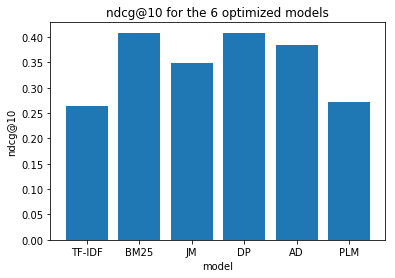

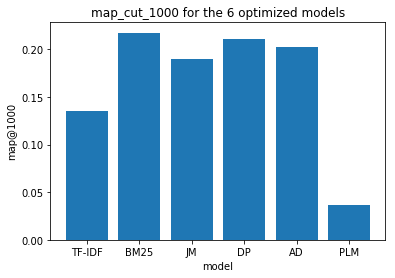

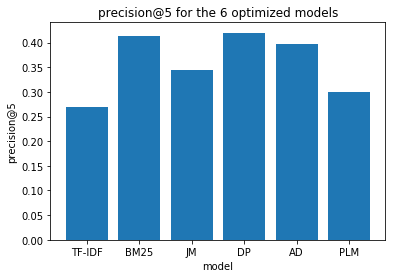

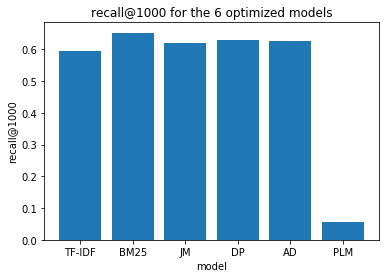

In [19]:

def create_barplot(x_obj, y_val, xtext, ytext, title):
    plt.bar(range(len(x_obj)), y_val)
    plt.xticks(range(len(x_obj)), x_obj)
    plt.ylabel(ytext)
    plt.xlabel(xtext)
    plt.title(title)
    plt.show()
#2
# 4 bar plots
#
# first 1, is for ndcg@10, 6 bars representing scores for the 6 optimized models
x_obj = ["TF-IDF","BM25","JM","DP","AD","PLM"]

y_val = [0.2635, 0.4086, 0.3489, 0.4085, 0.3853, 0.2716]
create_barplot(x_obj,y_val, "model", "ndcg@10", "ndcg@10 for the 6 optimized models")

y_val = [0.1352, 0.2173, 0.1893, 0.2104, 0.2027, 0.0368]
create_barplot(x_obj,y_val, "model", "map@1000", "map_cut_1000 for the 6 optimized models")

y_val = [0.2700, 0.4133, 0.3450, 0.4200, 0.3967, 0.3000]
create_barplot(x_obj,y_val, "model", "precision@5", "precision@5 for the 6 optimized models")

y_val = [0.5961, 0.6524, 0.6203, 0.6287, 0.6268, 0.0546]
create_barplot(x_obj,y_val, "model", "recall@1000", "recall@1000 for the 6 optimized models")


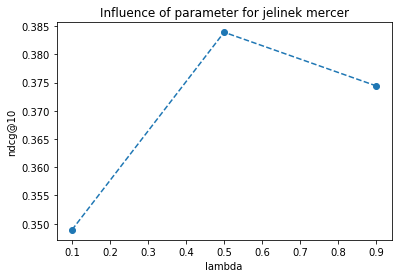

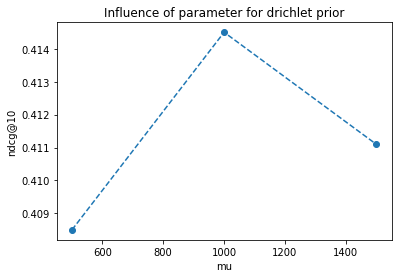

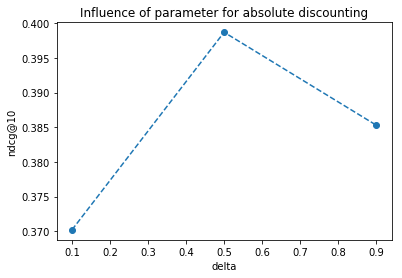

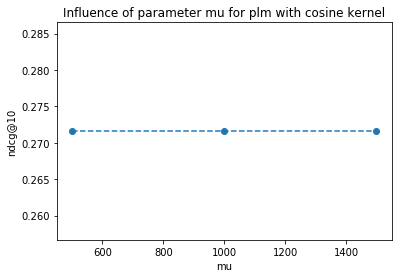

In [20]:
#3
# For JM 1 plot of 3 dots. Same for DP,AD
# For PLM we keep kernel fixed as kernel=...., then 1 plot of 3 dots again


def create_lineplot(x_val, y_val, xtext, ytext, title):
    plt.ylabel(ytext)
    plt.xlabel(xtext)
    plt.title(title)
    plt.plot(x_val, y_val, linestyle="--", marker="o")
    plt.show()
    

#jelinek_mercer, dirichlet_prior, absolute_discounting and plm
x_val = [0.1,0.5,0.9]
y_val = [0.3489, 0.3839, 0.3744]
create_lineplot(x_val, y_val, "lambda", "ndcg@10", "Influence of parameter for jelinek mercer")

x_val = [500,1000,1500]
y_val = [0.4085, 0.4145, 0.4111]
create_lineplot(x_val, y_val, "mu", "ndcg@10", "Influence of parameter for drichlet prior")

x_val = [0.1,0.5,0.9]
y_val = [0.3702, 0.3987, 0.3853]
create_lineplot(x_val, y_val, "delta", "ndcg@10", "Influence of parameter for absolute discounting")

x_val = [500,1000,1500]
y_val = [0.2716, 0.2716, 0.2716]
create_lineplot(x_val, y_val, "mu", "ndcg@10", "Influence of parameter mu for plm with cosine kernel")


In [21]:

# 4.
# statistical tests
from scipy import stats

model_names = ["tfidf","bm25","jelinek_mercer_01","dirichlet_prior_500", \
               "absolute_discounting_09","plm_KCO_500"]
model_info = []
for k in range(0,6):
    filename = "../scores_ndcg10_" + model_names[k]
#    filename = "../scores_map_" + model_names[k]
    lines = open(filename, 'r').read().strip().split('\n')
#    print(lines)
    info = {}
    for line in lines:
        x = line.split('\t')
        if x[1] != "all":
            info[x[1]] = x[2]
#    print(info)
    model_info.append(info)
    

# pairwise model comparison
for i in range(0,6):
    for j in range(i+1,6):
        
        x_list = []
        y_list = []
        for k in model_info[i].keys():
            x_list.append(float(model_info[i][k]))
            y_list.append(float(model_info[j][k]))


        result=stats.ttest_rel(x_list,y_list)
        print("result for: " + model_names[i] + "," + model_names[j])
        print(result)
        print("\n")

result for: tfidf,bm25
Ttest_relResult(statistic=-6.1630443720341859, pvalue=1.0059419873768143e-08)


result for: tfidf,jelinek_mercer_01
Ttest_relResult(statistic=-3.7648212801485452, pvalue=0.00026040003705856101)


result for: tfidf,dirichlet_prior_500
Ttest_relResult(statistic=-6.1385868715752636, pvalue=1.1307732886705352e-08)


result for: tfidf,absolute_discounting_09
Ttest_relResult(statistic=-5.1955813737392438, pvalue=8.5561686534955916e-07)


result for: tfidf,plm_KCO_500
Ttest_relResult(statistic=-0.96396771998754649, pvalue=0.33701693612219796)


result for: bm25,jelinek_mercer_01
Ttest_relResult(statistic=5.3413357102720038, pvalue=4.4963061059306401e-07)


result for: bm25,dirichlet_prior_500
Ttest_relResult(statistic=0.011558818163852598, pvalue=0.99079695874915585)


result for: bm25,absolute_discounting_09
Ttest_relResult(statistic=2.6048839498622884, pvalue=0.010362576596177453)


result for: bm25,plm_KCO_500
Ttest_relResult(statistic=5.9723155207341536, pvalue=2.48

In [ ]:
#5. Analysis of results is done in report, some extra checks for queries:

In [13]:
# examples of queries which give a very high evalutation score
#
#  Q96           tfidf    bm25         jm_01      dp_500  
#  ndcg@10        0.000   0.1461       0.000         0.6548

In [22]:
for token_id in tokenized_queries['96']:
    print(id2token[token_id])

computer
aided
medical
diagnosis


In [ ]:
# 96 Q0 AP891126-0021 1 107.63562883315164 tfidf
# 96 Q0 AP891113-0008 2 77.32280827797828 tfidf
# 96 Q0 AP881105-0083 3 77.32280827797828 tfidf
# 96 Q0 AP891023-0030 4 73.80813517443381 tfidf
# 96 Q0 AP891022-0098 5 73.80813517443381 tfidf

# 96 Q0 AP890120-0023 1 16.47093118517745 bm25
# 96 Q0 AP880512-0277 2 15.667488844237827 bm25
# 96 Q0 AP890919-0224 3 15.61729255330116 bm25
# 96 Q0 AP891128-0041 4 15.406418683592348 bm25
# 96 Q0 AP890119-0173 5 15.376201238047205 bm25

# 96 Q0 AP880512-0277 1 -31.318646178617172 jelinek_mercer_01
# 96 Q0 AP890120-0023 2 -31.79563655714457 jelinek_mercer_01
# 96 Q0 AP880830-0087 3 -31.910606245604953 jelinek_mercer_01
# 96 Q0 AP890213-0219 4 -31.968195322315367 jelinek_mercer_01
# 96 Q0 AP880726-0210 5 -32.072444609979485 jelinek_mercer_01

# 96 Q0 AP880506-0108 1 -29.488501102277695 dirichlet_prior_500
# 96 Q0 AP890120-0023 2 -29.96543153987153 dirichlet_prior_500
# 96 Q0 AP880419-0257 3 -30.005437644502816 dirichlet_prior_500
# 96 Q0 AP891128-0041 4 -30.073137716294585 dirichlet_prior_500
# 96 Q0 AP880308-0295 5 -30.21352863850371 dirichlet_prior_500

In [23]:
a1=document_lengths[index.document_ids(['AP891126-0021'])[0][1]]
a2=document_lengths[index.document_ids(['AP891113-0008'])[0][1]]
a3=document_lengths[index.document_ids(['AP881105-0083'])[0][1]]
a4=document_lengths[index.document_ids(['AP891023-0030'])[0][1]]
a5=document_lengths[index.document_ids(['AP891022-0098'])[0][1]]
print((a1+a2+a3+a4+a5)/5)
a1=document_lengths[index.document_ids(['AP890120-0023'])[0][1]]
a2=document_lengths[index.document_ids(['AP880512-0277'])[0][1]]
a3=document_lengths[index.document_ids(['AP890919-0224'])[0][1]]
a4=document_lengths[index.document_ids(['AP891128-0041'])[0][1]]
a5=document_lengths[index.document_ids(['AP890119-0173'])[0][1]]
print((a1+a2+a3+a4+a5)/5)
a1=document_lengths[index.document_ids(['AP880512-0277'])[0][1]]
a2=document_lengths[index.document_ids(['AP890120-0023'])[0][1]]
a3=document_lengths[index.document_ids(['AP880830-0087'])[0][1]]
a4=document_lengths[index.document_ids(['AP890213-0219'])[0][1]]
a5=document_lengths[index.document_ids(['AP880726-0210'])[0][1]]
print((a1+a2+a3+a4+a5)/5)
a1=document_lengths[index.document_ids(['AP880506-0108'])[0][1]]
a2=document_lengths[index.document_ids(['AP890120-0023'])[0][1]]
a3=document_lengths[index.document_ids(['AP880419-0257'])[0][1]]
a4=document_lengths[index.document_ids(['AP891128-0041'])[0][1]]
a5=document_lengths[index.document_ids(['AP880308-0295'])[0][1]]
print((a1+a2+a3+a4+a5)/5)

449.8
286.4
167.6
312.2


### Task 2: Latent Semantic Models (LSMs) [15 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

In [ ]:
# 1. We have a corpus corp_orig
# We first create a new corpus corp_tfidf by corp_tfidf=tfidfmodel[corp_orig], and then another transformationas
# corp_lsi=lsimodel[corp_tfidf]. Similarly corp_lda=ldamodel[corp_tfidf]
#
# Actually since we have hyperparameter=num_topics, which we want to optimize, we do it multiple times with
# different num_topics
#
# Now to compare how good the ranking works based on lsi and lda, we do:
#
# Check for queries q1,...,qN in query validation file, the following:
# 
# For a query qi, we get the top-1000 documents in the ranking generated by td-idf of task 1.
# For those 1000 documents we change them to vectors v1,...,v1000 in the lsimodel.
# We also convert qi, into a vector v_q in the lsimodel .
# We then do a similarity comparison between v_q and those vectors v1,...,v1000.
# The best similarity is ranked highest, the second most similar as 2nd, .....
# -> we get a ranking from the lsi model for this query
# We do same for all other queries.
#
# Repeat for ldamodel.
#

# 2. From the rankings gained from (1.), we use TREC_EVAL to report on
#  - NDCG@10
#  - MAP@1000
#  - Precision@5
#  - REcall@1000
#

# 3. To check if lsimodel is better than ldamodel.
# -> t-test
#


In [24]:
import gensim
from collections import Counter
from gensim import corpora, models, similarities

In [25]:
class corpus_class():
    def __init__(self, index):
        self.index = index
        
    def __iter__(self):
        for int_doc_id in range(self.index.document_base(), self.index.maximum_document()):
            ext_doc_id, doc_token_ids = index.document(int_doc_id)
            document_bow = collections.Counter(token_id for token_id in doc_token_ids if token_id > 0)
            a = list(document_bow.items())
            a.sort(key=lambda tup : tup[0], reverse=False)
            yield a

    def __len__(self):
        return self.index.maximum_document() - self.index.document_base()
    
corpus=corpus_class(index)

In [ ]:
# Transform the original model into tf-idf representation
tfidf_model = gensim.models.TfidfModel(corpus)
# Create the document vectors
corpus_tfidf=tfidf_model[corpus]

In [ ]:
# Define the lsm model with changeable number of features
def lsi(num_features):
    lsi_tfidf=models.LsiModel(corpus_tfidf, id2word=dictionary.id2token, num_topics=num_features)
    return lsi_tfidf
# Define the lda model with changeable number of features
def lda(num_features):
    lda_tfidf=models.LdaModel(corpus_tfidf, id2word=dictionary.id2token, num_topics=num_features)
    return lda_tfidf
# Define the similarity measure model with changeable number of features
def sim(lsm_model, num_features):
    if lsm_model=='lsi':
        index_for_sim = similarities.SparseMatrixSimilarity(lsi_tfidf[corpus_tfidf], num_features)
    if lsm_model=='lda':
        index_for_sim = similarities.SparseMatrixSimilarity(lda_tfidf[corpus_tfidf], num_features)       
    return index_for_sim

In [ ]:
#Define the lsm model which returns the top 1000 docs for each query
def lsi_top1000(query_id, lsi_tfidf, num_topics):
    query_term_ids = tokenized_queries[query_id]
    # Create a bow for each query
    bow = list(Counter(query_term_ids).items())
    bow.sort(key=lambda tup : tup[0], reverse=False)

    # Generate the corresponding lsi vector
    q_lsi_vector = lsi_tfidf[bow]
    
    # Get top 1000 documents for the query according to tfidf
    top1000_int_docs_id_tfidf = [k for score,k in tfidf_topN(query_id,1000)]
    
    # Convert those 1000 documents to vectors in lsi model
    docs_bow = []
    for i in range(0,len(top1000_int_docs_id_tfidf)):
        ext_doc_id, doc_token_ids = index.document(top1000_int_docs_id_tfidf[i])
        document_bow = collections.Counter(token_id for token_id in doc_token_ids if token_id > 0)
        a = list(document_bow.items())
        a.sort(key=lambda tup : tup[0], reverse=False)
        docs_bow.append(a)
    docs_lsi_vectors = lsi_tfidf[docs_bow]
    
    # Calculate the similarities between q_lsi_vector and those 1000 docs_lsi_vectors
    index_for_sim = similarities.SparseMatrixSimilarity(docs_lsi_vectors, num_topics)
    sims = index_for_sim[q_lsi_vector]
    scores_per_doc = [(val, index.document(top1000_int_docs_id_tfidf[i])[0]) for i,val in list(enumerate(sims))]
    
    return scores_per_doc

In [ ]:
#Define the lsm model which returns the top 1000 docs for each query
def lda_top1000(query_id, lda_tfidf, num_topics):
    query_term_ids = tokenized_queries[query_id]
    # Create a bow for each query
    bow = list(Counter(query_term_ids).items())
    bow.sort(key=lambda tup : tup[0], reverse=False)

    # Generate the corresponding lda vector
    q_lda_vector = lda_tfidf[bow]
    
    # Get top 1000 documents for the query according to tfidf
    top1000_int_docs_id_tfidf = [k for score,k in tfidf_topN(query_id,N)]
    
    # Convert those 1000 documents to vectors in lda model
    docs_bow = []
    for i in range(0,len(top1000_int_docs_id_tfidf)):
        ext_doc_id, doc_token_ids = index.document(top1000_int_docs_id_tfidf[i])
        document_bow = collections.Counter(token_id for token_id in doc_token_ids if token_id > 0)
        a = list(document_bow.items())
        a.sort(key=lambda tup : tup[0], reverse=False)
        docs_bow.append(a)
    docs_lda_vectors = lda_tfidf[docs_bow]
    
    # Calculate the similarities between q_lda_vector and those 1000 docs_lsi_vectors
    index_for_sim = similarities.SparseMatrixSimilarity(docs_lda_vectors, num_topics)
    sims = index_for_sim[q_lda_vector]
    scores_per_doc = [(val, index.document(top1000_int_docs_id_tfidf[i])[0]) for i,val in list(enumerate(sims))]
    
    return scores_per_doc

In [ ]:
def run_retrieval_lsm(model_name, score_model):
    data = {}
    run_out_path = '{}.run'.format(model_name)
    model_name = model_name
    t = time.time()
    for query_id, _ in tokenized_queries.items():
        data[query_id] = score_model(query_id, lsi_tfidf, num_topics)
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name = model_name,
            data = data,
            out_f=f_out)
    print(time.time()-t)
    return data

In [ ]:
def run_retrieval_lda(model_name, score_model):
    data = {}
    run_out_path = '{}.run'.format(model_name)
    model_name = model_name
    t = time.time()
    for query_id, _ in tokenized_queries.items():
        data[query_id] = score_model(query_id, lda_tfidf, num_topics)
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name = model_name,
            data = data,
            out_f=f_out)
    print(time.time()-t)
    return data

In [ ]:
t = time.time()
num_topics=20
lsi_tfidf = lsi(20)
index_for_sim = sim('lsi', 20)
run_retrieval_lda('lsi_20', lsi_top1000)
print(time.time()-t)

In [ ]:
t_1 = time.time()
num_topics=30
lda_tfidf = lda(30)
index_for_sim = sim('lda', 30)
run_retrieval_lsm('lda_30', lda_top1000)
print(time.time()-t_1)

In [ ]:
#After tuning the hyperparameters, we select the number of parameters 20 and 30
# for LSI and LDA respectively, results will be presented in details in the report.

# NDCG@10 Results
#   Model name|  avg NDCG@10 
#     LSI     |   0.1474
#     LDA     |   0.1578

# MAP@1000 Results
#   Model name|  MAP@1000
#     LSI     |   0.1068
#     LDA     |   0.1170

# Precision@5 Results
#   Model name|  Precision@5
#     LSI     |   0.1600
#     LDA     |   0.1733

# Recall@1000 Results
#   Model name|  Recall@1000
#     LSI     |   0.6695
#     LDA     |   0.6695

In [ ]:
# Statistical tests between LSI and LDA
from scipy import stats

eval_model_names = ["ndcg_10", "map", "precision", "recall"]
LSI= []
for i in range(len(eval_model_names)):
    filename = "score_test_lsi_20_"+ eval_model_names[i]   
#    filename = "../scores_map_" + model_names[k]
    lines = open(filename, 'r').read().strip().split('\n')
    info = {}
    for line in lines:
        x = line.split('\t')
        #print(x)
        if x[1] != "all":
            info[x[1]] = x[2]
            #print(info)
#    print(info)
    LSI.append(info)

LDA= []
for i in range(len(eval_model_names)):
    filename = "score_test_lda_30_"+ eval_model_names[i]   
#    filename = "../scores_map_" + model_names[k]
    lines = open(filename, 'r').read().strip().split('\n')
    #print(lines)
    info = {}
    for line in lines:
        x = line.split('\t')
        #print(x)
        if x[1] != "all":
            info[x[1]] = x[2]
#    print(info)
    LDA.append(info)

In [ ]:
for i in range(0,4):
    x_list = []
    y_list = []
    eval_name=eval_model_names[i]
    print("result for: " + eval_name )
    for j in LSI[i].keys():
        x_list.append(float(LSI[i][j]))
        y_list.append(float(LDA[i][j]))
    result=stats.ttest_ind(x_list,y_list, equal_var=False)  
    print(result)
    print("\n")
        

### Task 3:  Word embeddings for ranking [20 points] (open-ended) ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).
   
This is an open-ended task. It is left up you to decide how you will combine word embeddings to derive query and document representations. Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt.tar.gz). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

In [1]:
#
# 1. We have a corpus, we change words (with token !=0) in the vocabulary corpus to word embeddings using word2vec
#
# So if we have a query q=w1,w2,w3,w4, and assuming all of the words arent token 0, then we can define:
#  v_q1 = word2vec(w1), ... , v_q4 = word2vec(w4)     and v_Q = v_q1 + ... + v_q4
#
# Reasoning: the words in the query together aim towards a meaning.
#
#
# We want for a query q and a document d a score S(q,d):
#
# For any document d=w1,w2,...,wN similarly
#  v_d1 = word2vec(w1), ... v_dN = word2vec(wN)
# Now chose a K fixed, K = 12.
#
# define u_i = v_di + ... + v_d(i+K), then u_i has the goal of containing the meaning of K consecutinve
# words of the document at pos i.
#
# So for a document of length N, we can calculate u_1, ... u_(N-K)
#
# Now a score for each i in {1,...,N-K} can be calculated as
#    S(q,d,i) = similarity(u_i, v_q1 + ... + v_q4)
#
# and S(q,d) = max(S(q,d,i))
#
#

import gensim

# load trained model
word2vec_model = gensim.models.KeyedVectors.load('word2vec_model_5iter')

def score_using_word2vec(int_doc_id, query_token_ids, param):
    score = 0.0
    
    # calculate v_Q
    v_Q = 0.0
    for token_id in query_token_ids:
        if id2token[token_id] in word2vec_model:
            v_Q = v_Q + word2vec_model[id2token[token_id]]
    
    K = 12
    
    doc_orig = index.document(int_doc_id)[1]
    doc = []
    # remove words with tokenid=0
    for k in range(0,len(doc_orig)):
        if doc_orig[k] != 0:
            word = id2token[doc_orig[k]]
            if word in word2vec_model:
                doc.append(word)
    N = len(doc)

    if N >= K:
        pos_scores = np.zeros(N-K)
        for i in range(0,N-K):
            u_i = 0
            for word in doc[i:i+K]:
                u_i = u_i + word2vec_model[word]
            pos_scores[i] = np.dot(v_Q,u_i) / (np.linalg.norm(v_Q)*np.linalg.norm(u_i))
        score = max(pos_scores)
#        max_index = np.argmax(pos_scores)
#        print(doc[max_index:max_index+K])
    else:
        u = 0
        for word in doc:
            u = u + word2vec_model[word]
        score = np.dot(v_Q,u) / (np.linalg.norm(v_Q)*np.linalg.norm(u))
    
    return score


def run_retrieval_word2vec(model_name, param):
    data = {}
    run_out_path = '{}.run'.format(model_name)
    for query_id, query_token_ids in tokenized_queries.items():
        
        result = []
        # for each "good" document, calculate the doc_score, and append to results (doc_score, doc_id)
        good_docs = [k for score,k in tfidf_topN(query_id,100)]

        for k in good_docs:
            doc_score = score_using_word2vec(k, query_token_ids, param)
            doc_id = index.document(k)[0]
            result.append( (doc_score, doc_id) )

        data[query_id] = result
        
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name = model_name,
            data = data,
            out_f=f_out)
    return data



In [ ]:
t = time.time()
run_retrieval_word2vec('word2vec', [])
print(time.time() - t)

#### Task 4: Learning to rank (LTR) [15 points] (open-ended) ###

In this task you will get an introduction into learning to rank for information retrieval.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1, Task 2 and Task 3 as features. Think about other features you can use (e.g. query/document length). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

You are adviced to start some pointwise learning to rank algorithm e.g. logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set. More advanced learning to rank algorithms will be appreciated when grading.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np
import matplotlib.pyplot as plt

# supervised learning, data is of shape
#          X = [x1,
#               x2
#               ..
#               xN]
# each xi = [xi_1,...xi_K] (K-dim)
#    y = [y1,y2,...,yN],
# each yi is target (1-dim number) for input xi

# load data from q_validation file:
# data in file is of the form
#  144 0 AP880213-0185 0
#  query_id ..  doc_id relevance

############################################

# read in query-doc pair and relevance from test set
data_lines = open("ap_88_89/qrel_test", 'r').read().strip().split('\n')
data_qID_dID_pairs = []
data_y = []
for line in data_lines:
    info = line.split()
    data_qID_dID_pairs.append( (info[0], info[2]) )
    data_y.append(float(info[3]))


# filter pairs such that we only remember pairs where there is atleast 1 word of query in doc
good_data_pairs_qID_int_dID = []
good_data_y = []
for k in range(0,len(data_y)):
    q_ID,d_ID = data_qID_dID_pairs[k]

    if index.document_ids([d_ID]) != ():
        int_doc_id = index.document_ids([d_ID])[0][1]
    
        for token_id in tokenized_queries[q_ID]:

            # only want q,d pairs where atleast 1 word of q is in d
            if int_doc_id in inverted_index[token_id].keys():
                good_data_pairs_qID_int_dID.append((q_ID, int_doc_id))
                good_data_y.append(data_y[k])
                break

                
# divide filtered pairs into 10 folds
num_data = len(good_data_y)
fold_size = int(num_data/10)
data_pairs_folds = []
data_y_folds = []
for k in range(0,10):
    data_pairs_folds.append(good_data_pairs_qID_int_dID[k*fold_size:(k+1)*fold_size])
    data_y_folds.append(good_data_y[k*fold_size:(k+1)*fold_size])

    
# train nn
lr = LogisticRegression()
for e in range(0,10):

    for k in range(0,10):
        t = time.time()
        print("begin " + str(k))
        # train for fold k
        cur_pairs_x = []
        cur_y = []
        for j in range(0,10):
            if j != k:
                cur_pairs_x = cur_pairs_x + data_pairs_folds[j]
                cur_y = cur_y + data_y_folds[j]

        cur_input_X = [] ; cur_val_X = []
        cur_target_y = [] ; cur_val_y = []
        for j in range(0,10):

            for n in range(0,len(data_pairs_folds[j])):
                q_ID,int_doc_id = data_pairs_folds[j][n]

                # Calculate features for each query-doc pair
                features = []
                features.append(tfidf(int_doc_id, tokenized_queries[q_ID], []))
                features.append(bm25(int_doc_id, tokenized_queries[q_ID], [1.2,0.75]))
                
                if j != k:
                    cur_input_X.append(features)
                    cur_target_y.append(data_y_folds[j][n])
                else:
                    cur_val_X.append(features)
                    cur_val_y.append(data_y_folds[j][n])


        lr.fit(cur_input_X, cur_target_y)
        print("done " + str(k) + " ,time: " + str(time.time()-t))


        y_pred = lr.predict_proba(cur_val_X)

        print("loss: " + str(log_loss(cur_val_y,y_pred)))

In [ ]:
# create ranking with nn model

def run_retrieval_ltr(model_name, param):
    data = {}
    run_out_path = '{}.run'.format(model_name)
    for query_id, query_token_ids in tokenized_queries.items():
        
        result = []
        # for each "good" document, calculate the doc_score, and append to results (doc_score, doc_id)
        good_docs = [k for score,k in tfidf_topN(query_id,1000)]
        for k in good_docs:
            input_NN = [[tfidf(k, query_token_ids, []), bm25(k, query_token_ids, [1.2,0.75])]]
            doc_score = lr.predict_proba(input_NN)[0][1]
            doc_id = index.document(k)[0]
            result.append( (doc_score, doc_id) )

        data[query_id] = result
        
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name = model_name,
            data = data,
            out_f=f_out)
    return data

t = time.time()
run_retrieval_ltr('ltr', [])
print(time.time() - t)

### Task 4: Write a report [15 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.
